In [1]:
import sys
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

In [2]:
sys.path.append('../')

from spikennet.utils.augmentation import DataGenerator

## 1. Upload data

In [3]:
dataset = pd.read_csv('../data/raw/Supersonic-project/datset_02_2021.csv')

In [4]:
# All combinations of 'Frequency' and 'Amplitude'
keys = dataset[['Frequency', 'Amplitude']]\
                                    .groupby(by=['Frequency', 'Amplitude'])\
                                    .sum()\
                                    .reset_index()\
                                    .to_numpy()

# Select index of combination of 'Frequency' and 'Amplitude'
key_index = 1
# Select value of combination of 'Frequency' and 'Amplitude'
keys[key_index]

# Define filter query for selecting data
filter_query = 'Frequency == {0} & Amplitude == {1}'.format(*keys[key_index])
# Select data with same combination of 'Frequency' and 'Amplitude'
data = dataset.query(filter_query)

In [5]:
# Clean data
clean_data_start_perc = 0.5 
clean_data_start_index = int(len(data)*clean_data_start_perc)
# Select columns 
columns = ['Time', 'left_yaw', 'right_yaw', 'rot_angle_y_gf', 'rot_angle_z_gf']

data = data[clean_data_start_index:][columns].values

Text(0.5, 0.98, 'States')

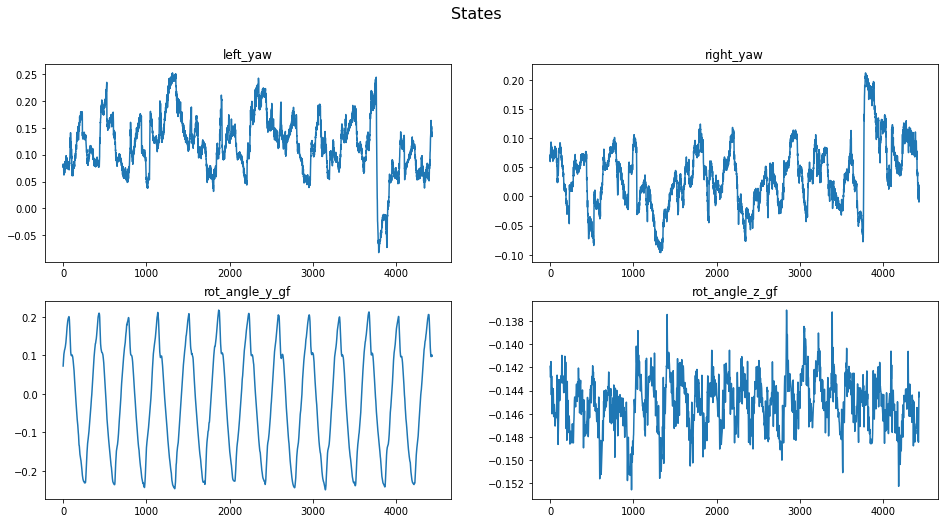

In [6]:
fig = plt.figure(figsize=(16, 8))

for i in range(len(columns)-1):
    ax = fig.add_subplot(2, 2, i+1)
    ax.plot(data.T[1+i])
    ax.set_title(columns[1+i])
    
fig.suptitle('States', fontsize=16)

## 2. Prepare data

### 2.1 Data split

In [7]:
# Number of window
k_windows = 5
# Width of window
width = int(len(data)/k_windows)

start_index = 0
end_index = width
(N,M) = data.shape

# Storage of windows
windows = np.zeros(shape=(k_windows, width, M))

In [8]:
windows[0].shape

(886, 5)

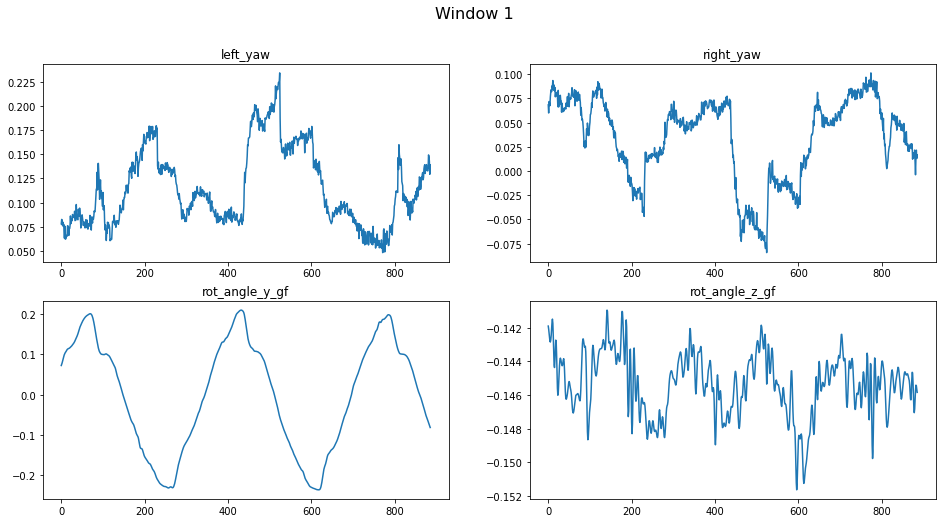

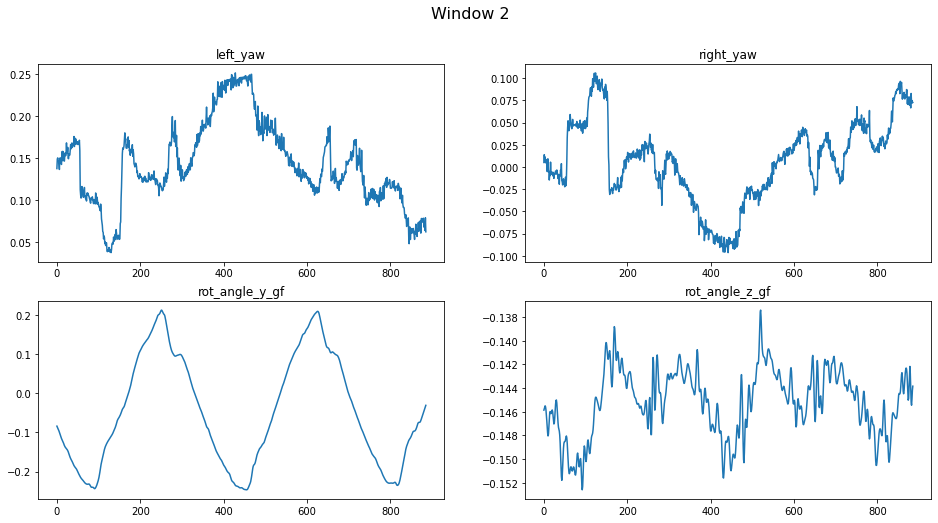

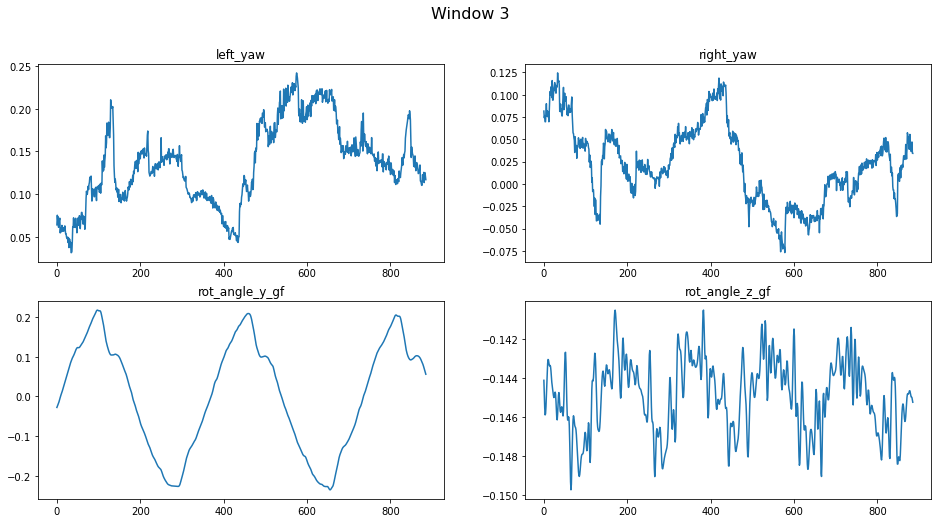

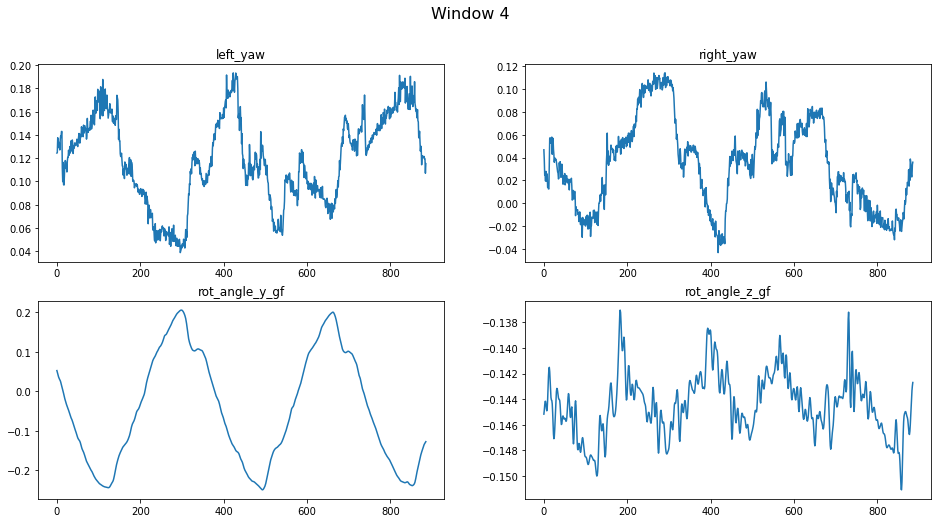

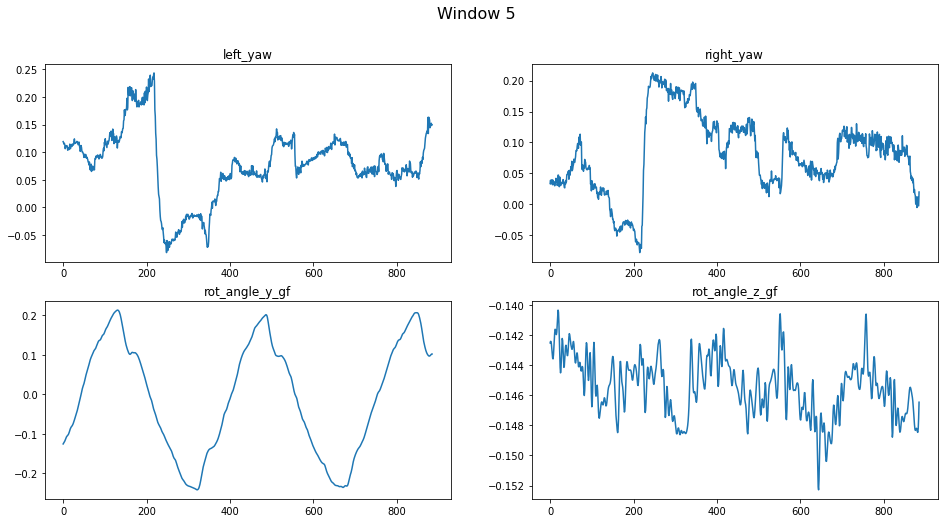

In [9]:
for k in range(k_windows):
    fig = plt.figure(figsize=(16, 8))
    tmp_data = data[start_index:end_index]
    for i in range(len(columns)-1):
        ax = fig.add_subplot(2, 2, i+1)
        ax.plot(tmp_data.T[1+i])
        ax.set_title(columns[1+i])
    
    windows[k] = tmp_data
    start_index = end_index 
    end_index += width
        
    fig.suptitle('Window {0}'.format(1+k), fontsize=16)

### 2.2 Data augmentation

In [10]:
# Object of class data-augmentation
dg = DataGenerator()

In [11]:
# Set the window for work
window_index = 1

In [12]:
# Count of exemple (k-1) synthetic data
k_augmentations = 6
# Storage of augmentations
augmentations = np.zeros(shape=(k_augmentations, width, M))

# Generate synthetic data
augmentations[0] = windows[window_index]
augmentations[1] = dg.time_inverse(windows[window_index])

for i in range(2, k_augmentations, 2):
    
    surrogate_fft = 0.8*windows[window_index] + 0.3*dg.fft(windows[window_index])
    surrogate_fft_ti = dg.time_inverse(surrogate_fft)

    augmentations[i] = surrogate_fft
    augmentations[i+1] = surrogate_fft_ti

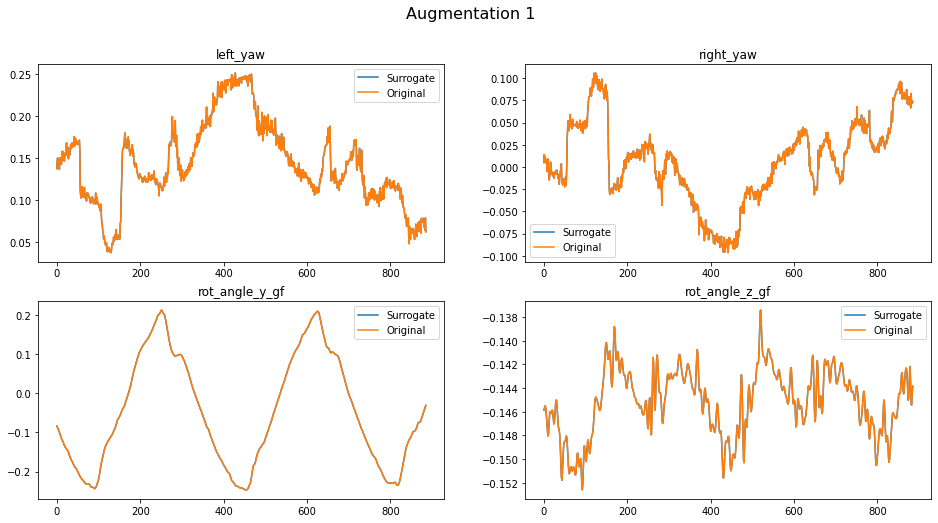

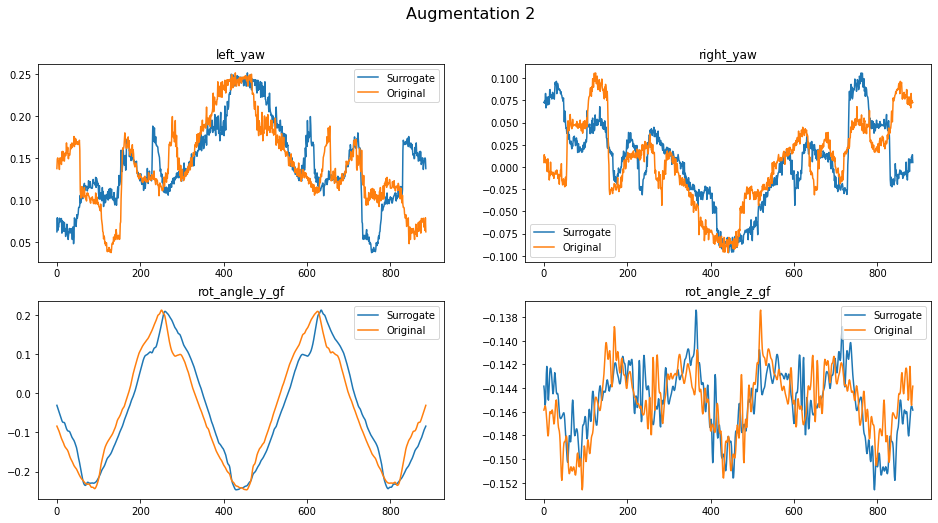

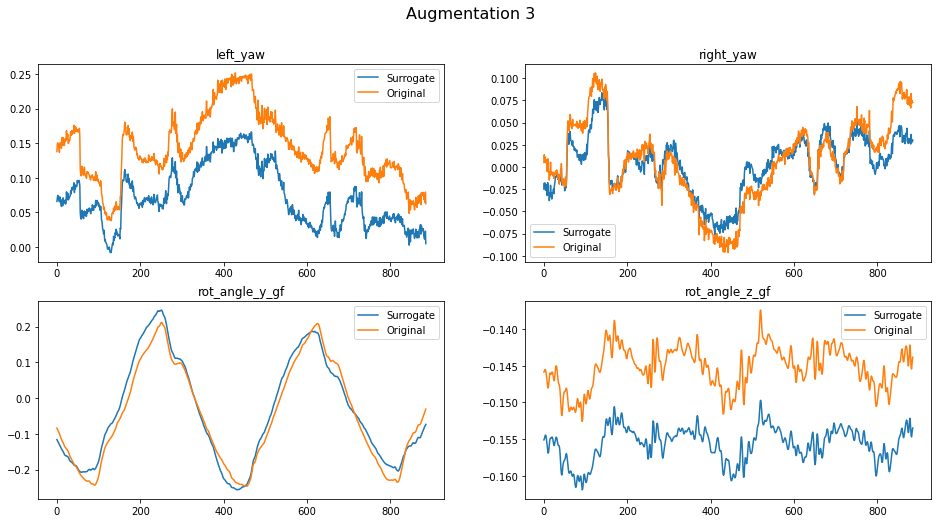

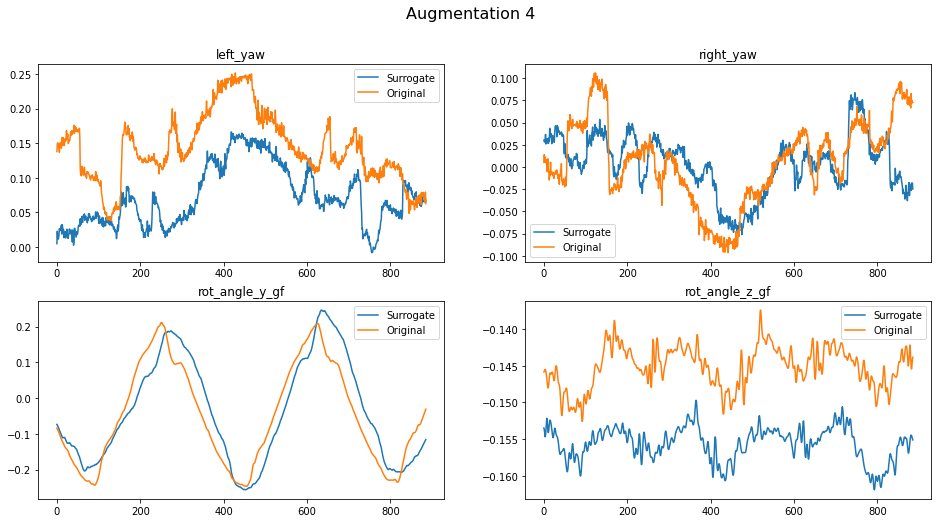

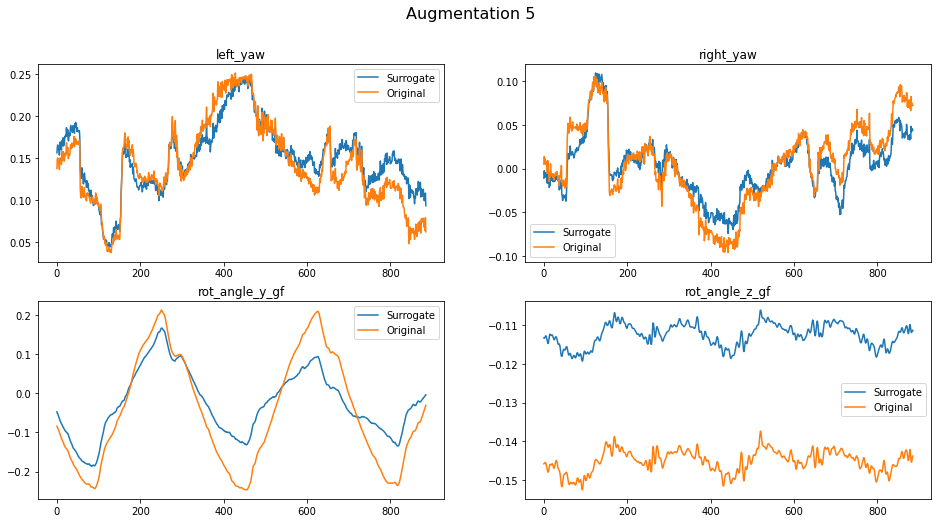

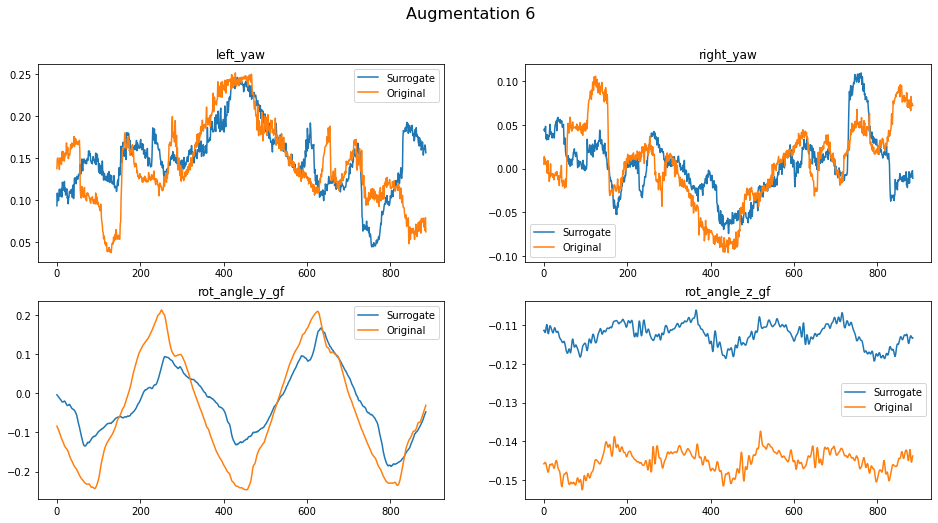

In [13]:
# Plot augmentations
for k in range(k_augmentations):
    fig = plt.figure(figsize=(16, 8))
    tmp_data = augmentations[k]
    for i in range(len(columns)-1):
        ax = fig.add_subplot(2, 2, i+1)
        ax.plot(tmp_data.T[1+i])
        ax.plot(augmentations[0].T[1+i])
        ax.legend(['Surrogate', 'Original'])
        ax.set_title(columns[1+i])
            
    fig.suptitle('Augmentation {0}'.format(1+k), fontsize=16)